In [189]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [190]:
df = pd.read_csv('netflix_ratings_data.csv', sep = ',')

In [191]:
df['splitted_genre'] = df['genres'].str.split(',')
genre_df = pd.DataFrame({'col':df['splitted_genre']})
genre_df = genre_df.explode('col')

In [192]:
genre_df = genre_df.drop_duplicates()
genre_df = genre_df.drop([372])
genre_data = genre_df.reset_index(drop=True)

In [193]:
title_genre = df[['title','splitted_genre']]

In [194]:
title_genre_2 = title_genre.copy()
title_genre_2 =title_genre_2.explode('splitted_genre') 

In [195]:
genre_title_count = title_genre_2.groupby('splitted_genre').size().reset_index(name='counts')

In [196]:
genre_title_count = genre_title_count.sort_values(by = 'counts', ascending = True)

In [197]:
genre_title_count

,splitted_genre,counts
1,Adult,4
17,News,7
23,Talk-Show,9
27,\N,12
26,Western,21
11,Game-Show,29
25,War,73
15,Musical,78
18,Reality-TV,115
22,Sport,165


<ipython-input-198-778378323164>:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='blue',


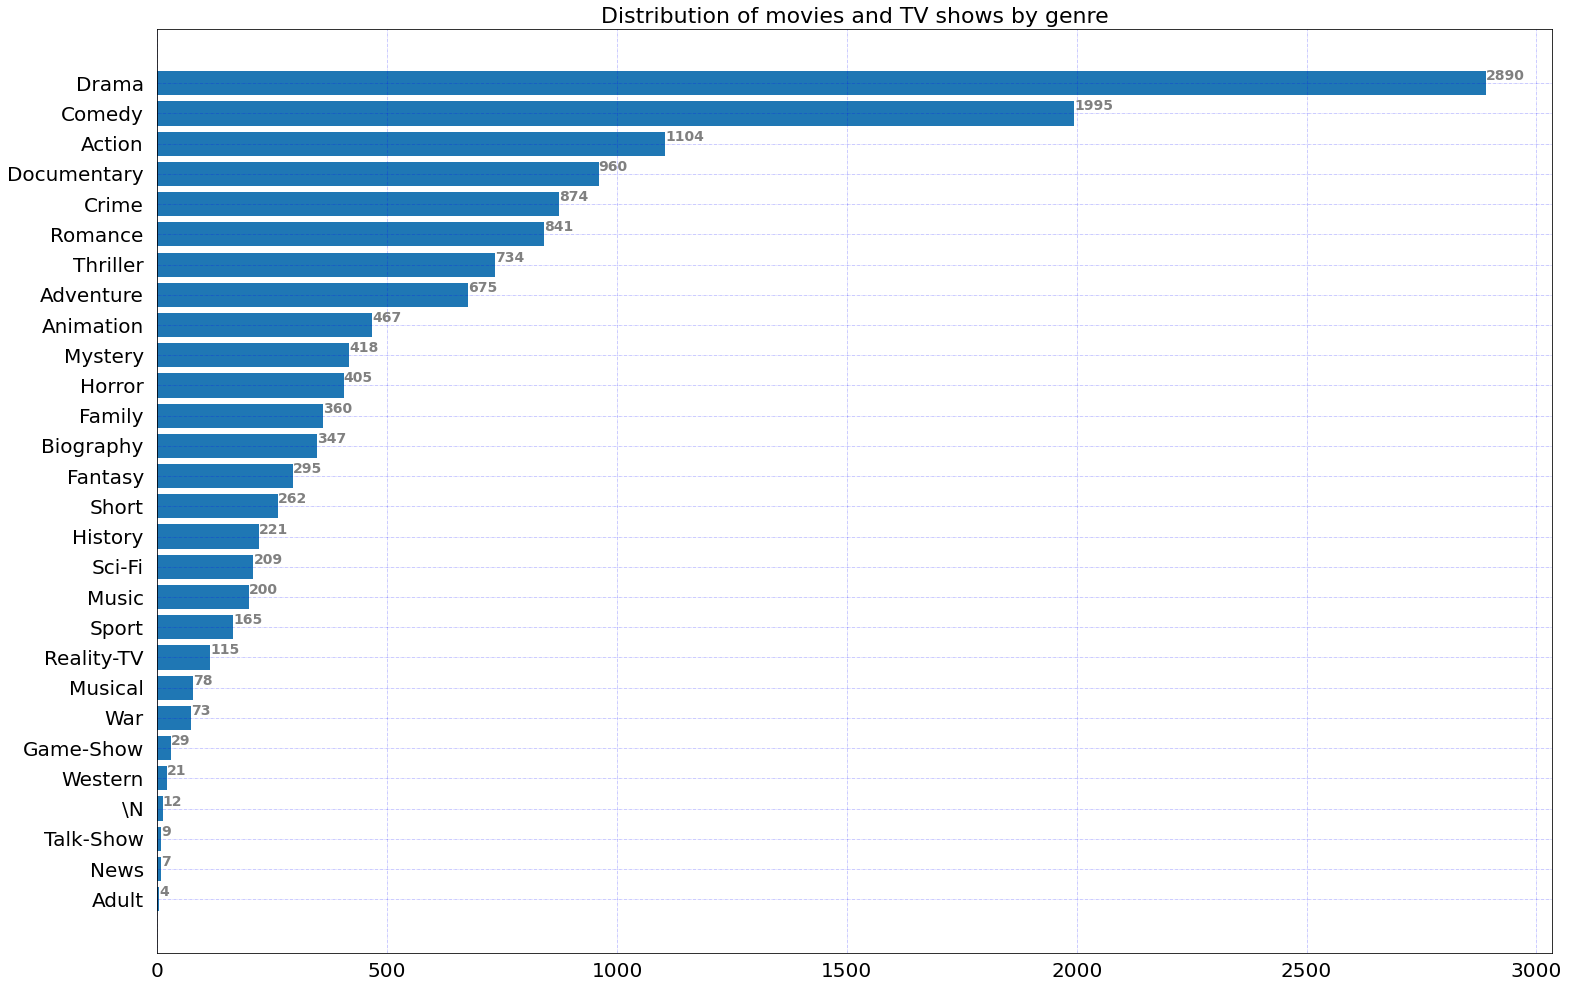

In [198]:
#Reference: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
genre = genre_title_count['splitted_genre']
number_of_titles = genre_title_count['counts']
fig, ax = plt.subplots(figsize =(25, 17))
ax.barh(genre, number_of_titles)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='blue',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.4)
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 14, fontweight ='bold',
             color ='grey')
ax.set_title('Distribution of movies and TV shows by genre', loc = 'center',fontsize = 22,)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.savefig('bar_plot_title_distribution.png')
plt.show()



In [199]:
title_genre_4 = df[['splitted_genre','averageRating', 'year']]
title_genre_4 = title_genre_4.explode('splitted_genre')
yearly_groupped = title_genre_4.groupby('year').size().reset_index(name = 'count')

In [200]:
yearly_groupped = yearly_groupped[yearly_groupped['year'] > 2000]
subset_year = title_genre_4[title_genre_4['year']>2008]
subset_year = subset_year.set_index('year')

In [201]:
subset_year = subset_year.groupby(['splitted_genre','year'])['averageRating'].mean().reset_index()


In [202]:
subset_year =subset_year.set_index('splitted_genre')

In [203]:
subset_year_2 = subset_year.loc[['Action', 'Comedy','Drama','Documentary','Crime',
                                 'Romance','Thriller','Adventure','Animation']].reset_index()

In [204]:
list_p =[]
genre_list = ['Action', 'Comedy','Drama','Documentary','Crime',
                                 'Romance','Thriller','Adventure','Animation']
for i in genre_list:
    subset_genre = subset_year_2[subset_year_2['splitted_genre']==i] 
    normal_cal = stats.normaltest(subset_genre['averageRating']).pvalue
    print(i, normal_cal)


Action 0.37934953132704763
Comedy 0.03323877201350682
Drama 0.330347837353399
Documentary 0.17541988147958135
Crime 0.00824223315070125
Romance 0.5806409446843395
Thriller 0.09351754398292038
Adventure 0.16364399476344912
Animation 0.44188770833945024


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Crime', ylabel='Density'>

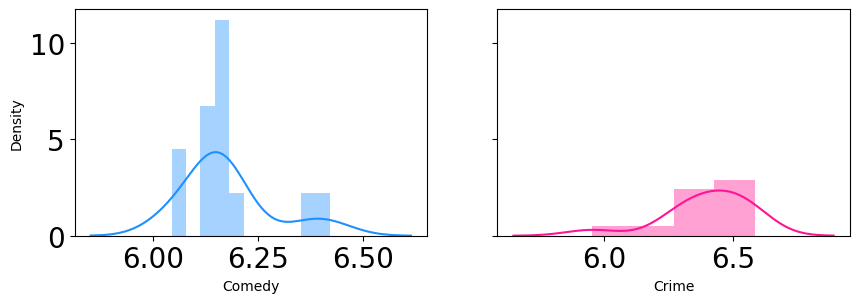

In [205]:
#We can see that Comedy and Crime data is not normal 
comedy_df = subset_year_2[subset_year_2['splitted_genre']=='Comedy'].drop(columns=['year'])
crime_df = subset_year_2[subset_year_2['splitted_genre']=='Crime'].drop(columns=['year'])

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(comedy_df['averageRating'] , color="dodgerblue", ax=axes[0], axlabel='Comedy')
sns.distplot(crime_df['averageRating'] , color="deeppink", ax=axes[1], axlabel='Crime')


In [206]:
genre_list = ['Action', 'Comedy','Drama','Documentary','Crime',
                                 'Romance','Thriller','Adventure','Animation']
action_df = subset_year_2[subset_year_2['splitted_genre']=='Action'].drop(columns=['year'])
drama_df = subset_year_2[subset_year_2['splitted_genre']=='Drama'].drop(columns=['year'])
documentary_df = subset_year_2[subset_year_2['splitted_genre']=='Documentary'].drop(columns=['year'])
romance_df = subset_year_2[subset_year_2['splitted_genre']=='Romance'].drop(columns=['year'])
thriller_df = subset_year_2[subset_year_2['splitted_genre']=='Thriller'].drop(columns=['year'])
adventure_df = subset_year_2[subset_year_2['splitted_genre']=='Adventure'].drop(columns=['year'])
animation_df = subset_year_2[subset_year_2['splitted_genre']=='Animation'].drop(columns=['year'])


In [207]:
initial_levene_p = stats.levene(action_df['averageRating'], drama_df['averageRating'], documentary_df['averageRating'], romance_df['averageRating'],
                                thriller_df['averageRating'],adventure_df['averageRating'], animation_df['averageRating']).pvalue
print(initial_levene_p)

0.4028232261863258


Anova p-value:  3.122429817488909e-23
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
     action   adventure   0.1807 0.2823 -0.0622  0.4237  False
     action   animation   0.5119  0.001   0.269  0.7549   True
     action documentary   0.9784  0.001  0.7354  1.2213   True
     action       drama   0.4104  0.001  0.1675  0.6534   True
     action     romance   0.3124 0.0037  0.0695  0.5553   True
     action    thriller  -0.1401  0.578 -0.3831  0.1028  False
  adventure   animation   0.3312 0.0017  0.0883  0.5742   True
  adventure documentary   0.7976  0.001  0.5547  1.0406   True
  adventure       drama   0.2297 0.0765 -0.0132  0.4726  False
  adventure     romance   0.1317 0.6385 -0.1113  0.3746  False
  adventure    thriller  -0.3208 0.0026 -0.5638 -0.0779   True
  animation documentary   0.4664  0.001  0.2235  0.7094   True
  animation      

<ipython-input-208-4ae9ae6809b3>:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='blue',


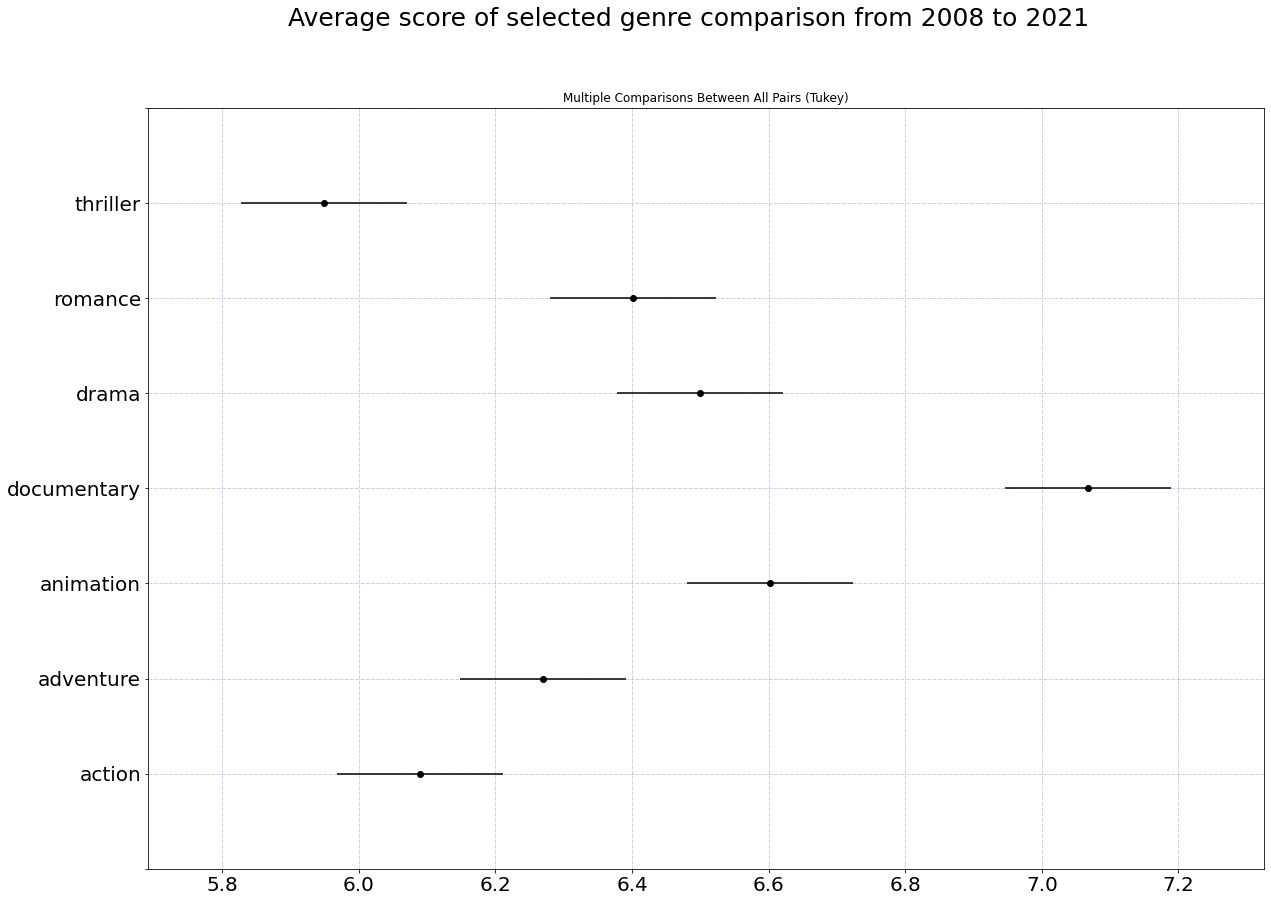

In [208]:
#They have equal variance=>Proceed with ANOVA test
anova = stats.f_oneway(action_df['averageRating'],      drama_df['averageRating'],
                       documentary_df['averageRating'], romance_df['averageRating'],
                       thriller_df['averageRating'],     adventure_df['averageRating'], 
                       animation_df['averageRating'])
print("Anova p-value: ", anova.pvalue)
data = pd.DataFrame({'action': action_df['averageRating'].tolist(),
                        'drama': drama_df['averageRating'].tolist(),
                        'documentary': documentary_df['averageRating'].tolist(),
                        'romance': romance_df['averageRating'].tolist(),
                        'thriller': thriller_df['averageRating'].tolist(),
                        'adventure': adventure_df['averageRating'].tolist(),
                        'animation': animation_df['averageRating'].tolist()})

melted = pd.melt(data)
posthoc = pairwise_tukeyhsd(
    melted['value'], melted['variable'],
    alpha=0.05)
print(posthoc)
ax = plt.axes()
ax.yaxis.label.set_size(16)
ax.xaxis.label.set_size(18)
ax.grid(b = True, color ='blue',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.4)
fig = posthoc.plot_simultaneous(ax=ax, figsize=(20, 14))
fig.suptitle('Average score of selected genre comparison from 2008 to 2021', fontsize=25)
fig.savefig("posthoc.png")